# Приоритизация гипотез и А/В-тест для крупного интернет-магазина 

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [5]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


## Приоритизация гипотез

### ICE

In [6]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


### RICE

In [7]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Ранжирование гипотез при оптимизации методами ICE и RICE отличается. Однако в обоих случаях в первой тройке можно наблюдать гипотезы 7 и 0. Гипотеза 2 вышла на второе место исключительно благодаря высоким показателям охвата аудитории, а гипотеза 8 имеет довольно малый охват, т.к. при оптимизации методом RICE сдвинулась ближе к середине списка.

## Анализ А/В-теста

### Динамика кумулятивных метрик

In [8]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [9]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [10]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
    .agg({'date' : 'max',
          'ordersPerDateA' : 'sum',
          'revenuePerDateA' : 'sum'}),
    axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
    .agg({'date' : 'max',
          'ordersPerDateB' : 'sum',
          'revenuePerDateB' : 'sum'}),
    axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

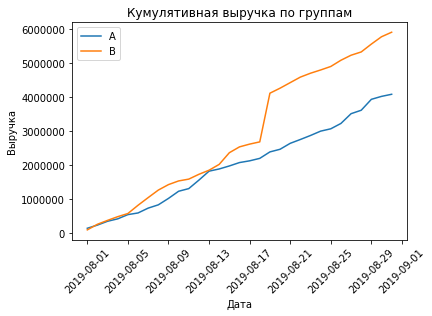

In [30]:
plt.plot(ordersACummulative['date'], ordersACummulative['revenueCummulativeA'], label='A')

plt.plot(ordersBCummulative['date'], ordersBCummulative['revenueCummulativeB'], label='B')

plt.legend()
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка по группам')
plt.xticks(rotation=45);

В группе В в районе 18-08-2019 наблюдается резкий рост выручки. Это свидетельствует либо о резком увеличении числа заказаов, либо о наличии заказов на крупную сумму. Подобные выбросы следует отфильтровать в дальнейшем.

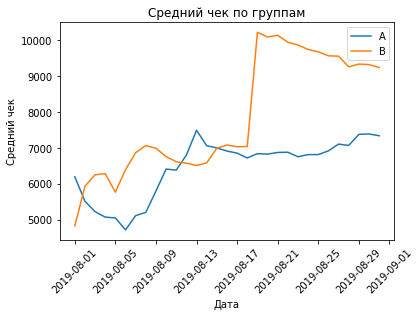

In [12]:
plt.plot(ordersACummulative['date'],
         ordersACummulative['revenueCummulativeA'] / ordersACummulative['ordersCummulativeA'],
         label='A')

plt.plot(ordersBCummulative['date'],
         ordersBCummulative['revenueCummulativeB'] / ordersBCummulative['ordersCummulativeB'],
         label='B')

plt.legend()
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Средний чек по группам')
plt.xticks(rotation=45);

Оба графика имеют скачкообразную динамику. Однако группа А к концу эксперимента выровнялась, что сложно сказать о группе В, которой помешал резкий скачок среднего чека в районе 18-08-2019.

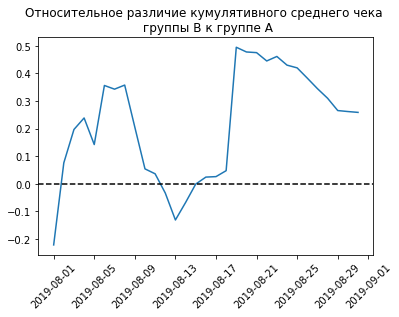

In [13]:
#строим объединённую таблицу с выручкой
CummulativeRevenue = pd.merge(ordersACummulative, ordersBCummulative, on='date')

plt.plot(CummulativeRevenue['date'],
         (CummulativeRevenue['revenueCummulativeB'] / CummulativeRevenue['ordersCummulativeB']) / (CummulativeRevenue['revenueCummulativeA'] 
          / CummulativeRevenue['ordersCummulativeA'])  - 1)

plt.title('Относительное различие кумулятивного среднего чека \n группы В к группе А')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--');

Резкие скачки графика наблюдаются в нескольких местах. Наибольшее различие в 50% наблюдается в середине месяца. 

In [14]:
cummulativeDataA = pd.merge(ordersACummulative, visitorsACummulative, on='date')
cummulativeDataB = pd.merge(ordersBCummulative, visitorsBCummulative, on='date')

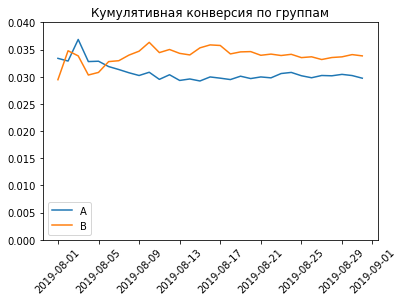

In [15]:
cummulativeDataA['conversionA'] = cummulativeDataA['ordersCummulativeA'] / cummulativeDataA['visitorsCummulativeA']
cummulativeDataB['conversionB'] = cummulativeDataB['ordersCummulativeB'] / cummulativeDataB['visitorsCummulativeB']

plt.plot(cummulativeDataA['date'], cummulativeDataA['conversionA'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversionB'], label='B')

plt.ylim((0, 0.04))
plt.title('Кумулятивная конверсия по группам')
plt.xticks(rotation=45)
plt.legend();

Группы колеблются в диапазоне значений от 3% до 4%. Конверсия группы В после первой недели теста обогнала конверсию группы А, и обе достигли относительной стабильности. График симметричен.

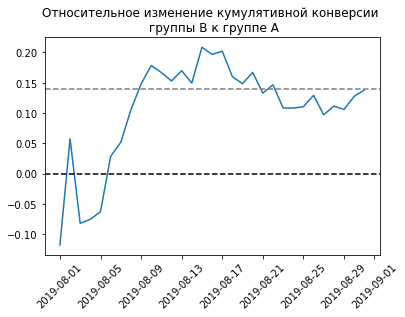

In [16]:
cummulativeData = pd.merge(cummulativeDataA, cummulativeDataB, on='date')

plt.plot(cummulativeData['date'], cummulativeData['conversionB'] / cummulativeData['conversionA'] - 1)
plt.title('Относительное изменение кумулятивной конверсии \n группы B к группе A')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--');

В течение первой недели теста конверсия группы В была ниже конверсси группы А, но затем разница в конверсии начала резко увеличиваться, пока не достигла пика в середине месяца. Затем она начала падать, но всё ещё оставалась в положительной зоне. К концу месяца разница конверсии составила около 14% в пользу группы В.

### Анализ выбросов

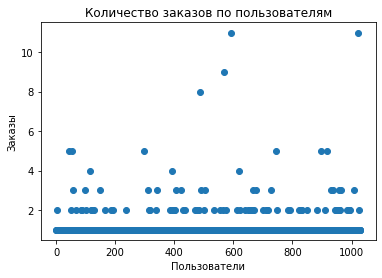

In [17]:
ordersByVisitors = orders.groupby('visitorId').agg({'transactionId': 'nunique'}).reset_index()
ordersByVisitors = ordersByVisitors.rename(columns={'transactionId': 'transactions'})

x_values = pd.Series(range(0,len(ordersByVisitors)))
plt.scatter(x_values, ordersByVisitors['transactions'])
plt.xlabel('Пользователи')
plt.ylabel('Заказы')
plt.title('Количество заказов по пользователям');

Абсолютное большинство покупателей сделали только 1 заказ, несколько из них сделали 2. Количество пользователей, сделавших более 2 заказов, крайне мало.

In [18]:
np.percentile(ordersByVisitors['transactions'], [95,99])

array([2., 4.])

Не более 5% пользователей делали больше 2 заказов. В качестве условия для фильтрации выбросов выберем тех пользователей, которые совершили до 2 покупок включительно.

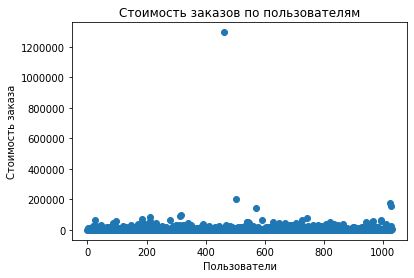

In [19]:
revenueByVisitors = orders.groupby('visitorId').agg({'revenue': 'sum'}).reset_index()

xValues = pd.Series(range(0,len(revenueByVisitors)))
plt.scatter(xValues, revenueByVisitors['revenue'])
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость заказов по пользователям');

Явно просматривается выброс со стоимость заказа более 1,2 млн. Также довольно мало заказов со стоимостью в районе 200 тыс.

In [20]:
np.percentile(revenueByVisitors['revenue'], [95,99])

array([32899.5, 67750. ])

Не более 5% пользователей оформили заказ более чем на 32 900. Поставим условием для фильтрации выбросов заказы на сумму менее 33 000.

### Расчёт статистической значимости

In [21]:
#объединение всех датафреймов с кумулятивными и дневными метриками в один
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [22]:
#создаём датафреймы с количеством заказов на посетителя по группам
ordersByVisitorsA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByVisitorsA.columns = ['visitorId', 'orders']

ordersByVisitorsB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByVisitorsB.columns = ['visitorId', 'orders']

In [23]:
#подготовка данных к применению критерия Манна-Уитни
sampleA = pd.concat(
    [ordersByVisitorsA['orders'],pd.Series(0, index=np.arange(
        data['visitorsPerDateA'].sum() - len(ordersByVisitorsA['orders'])), name='orders')],axis=0)

sampleB = pd.concat(
    [ordersByVisitorsB['orders'],pd.Series(0, index=np.arange(
        data['visitorsPerDateB'].sum() - len(ordersByVisitorsB['orders'])), name='orders')],axis=0)

In [24]:
print("p-значение: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост конверсии группы В: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

p-значение: 0.008
Относительный прирост конверсии группы В: 0.138


Р-значение меньше статистической значимости 0,05, соотвественно, нулевая гипотеза о том, что статистически значимых различий в конверсии между группами нет, может быть отвергнута. Относительный прирост конверсии группы В равен 13,8%.

In [25]:
#применение критерия для среднего чека
revenueByGroupA = orders[orders['group'] == 'A']['revenue']
revenueByGroupB = orders[orders['group'] == 'B']['revenue']

print("р-значение: {0:.3f}". format(stats.mannwhitneyu(revenueByGroupA, revenueByGroupB)[1]))
print("Относительный прирост среднего чека группы В: {0:.3f}".format(revenueByGroupB.mean() / revenueByGroupA.mean() - 1))

р-значение: 0.365
Относительный прирост среднего чека группы В: 0.259


Р-значение выше уровня статистической значимости 0,05. Соответственно, нулевая гипотеза об отсутствии статистически значимых различий между группами А и В верна. Прирост среднего чека группы В равен 25,9%.

#### Удаление аномальных значений

In [26]:
#характеристика аномальных значений:
#- оформление более 2 заказов
#- сумма заказов выше 33 000

visitorsWithManyOrders = ordersByVisitors[ordersByVisitors['transactions'] > 2]['visitorId']
visitorsWithExpensiveOrders = revenueByVisitors[revenueByVisitors['revenue'] >= 33000]['visitorId']

abnormalUsers = pd.concat([visitorsWithManyOrders, visitorsWithExpensiveOrders], axis=0).drop_duplicates().sort_values()
abnormalUsers.shape

(71,)

Среди всех пользователей 71 соответсвует условиям аномальных значений.

In [27]:
ordersByVisitorsAFiltered = ordersByVisitorsA[np.logical_not(ordersByVisitorsA['visitorId'].isin(abnormalUsers))]
ordersByVisitorsBFiltered = ordersByVisitorsB[np.logical_not(ordersByVisitorsB['visitorId'].isin(abnormalUsers))]

sampleAFiltered = pd.concat([ordersByVisitorsAFiltered['orders'], 
                             pd.Series(0, 
                                       index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByVisitorsA['orders'])),
                                       name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByVisitorsBFiltered['orders'], 
                             pd.Series(0, 
                                       index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByVisitorsB['orders'])),
                                       name='orders')], axis=0)

In [28]:
print("p-значение: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительный прирост конверсии группы В: {0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение: 0.005
Относительный прирост конверсии группы В: 0.178


P-значение уменьшилось и всё ещё находится ниже уровня статистической значимости. Следовательно, после очистки данных от выбросов нулевая гипотеза всё равно остаётся неверной. Относительный прирост конверсии группы В увеличился после очистки и составил 17,8%. 

In [29]:
revenueAFiltered = orders[np.logical_and(
    orders['group'] == 'A',
    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
revenueBFiltered = orders[np.logical_and(
    orders['group'] == 'B',
    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

print("p-значение: {0:.3f}".format(stats.mannwhitneyu(revenueAFiltered, revenueBFiltered)[1]))
print("Относительный прирост среднего чека группы В: {0:.3f}".format(revenueBFiltered.mean() / revenueAFiltered.mean() - 1))

p-значение: 0.399
Относительный прирост среднего чека группы В: -0.012


P-значение не сильно изменилось, нулевая гипотеза верна. Однако относительный прирост значительно изменился, причём в противоположную сторону. После отсечения аномальных значений оказалось, что группы В и А практически не отличаются по среднему чеку, т.к. различие составляет всего 1,2% в пользу группы А.

## Выводы

- Как по "сырым", так и по "очищенным" данным статистически значимые отличия между группами есть. Конверсия группы В определённо выше конверсии группы А.
- Статистически значимых отличий по среднему чеку в группах А и В нет как по "сырым", так и по "очищенным" данным. Однако после очистики оказалось, что средние чеки можно считать практически равными (разница около 1% в пользу группы А)
- График различия конверсий показывает, что по этому показателю в действительности группа В опережает группу А.
- График различия среднего чека сложно интерпретировать, т.к. он отображает слишком много выбросов.

Таким образом, получается, что средний чек группы В примерно равен среднему чеку группы А, но конверсия у неё выше. То есть группа В совершает покупку на ту же сумму, только она более многочисленна, что должно привести к увеличению выручки.

**Итог:**
Тест следует остановить и зафиксировать победу группы В.